# Explore Data: Session 5

April 6, 2022

* Process json --> numpy
* Visualize trace
* PCA
* SVM

In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt

import glob

import bisect
import random

from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt

In [2]:
meta_data_path = "meta_session_5.tsv"
jsons_base_path = "raw_data_session_5/"
FIG_SIZE = (10, 7)
random.seed(42)

## Load Meta Data

In [3]:
# load meta_data
meta_data = pd.read_csv(meta_data_path, sep="\t", header=1)
meta_data = meta_data[meta_data["Keep"] == "keep"]
meta_data = meta_data[["Username", "Intent", "Replicate", "Keep"]]
meta_data = meta_data.reset_index()
meta_data["trial"] = meta_data.index
meta_data["firebase"] = meta_data.apply(lambda x: x["Username"] + str(x["Intent"]) + str(x["Replicate"]), axis=1)
meta_data

,index,Username,Intent,Replicate,Keep,trial,firebase
0,0,Eamon,A,1,keep,0,EamonA1
1,1,Eamon,B,1,keep,1,EamonB1
2,2,Eamon,C,1,keep,2,EamonC1
3,7,Myles,B,1,keep,3,MylesB1
4,9,Charlie,A,1,keep,4,CharlieA1
5,10,Charlie,B,1,keep,5,CharlieB1
6,12,Alessandra,A,1,keep,6,AlessandraA1
7,13,Alessandra,B,1,keep,7,AlessandraB1
8,14,Alessandra,C,1,keep,8,AlessandraC1
9,18,Ben,A,1,keep,9,BenA1


In [4]:
def parse_json(entry=0, visualize_trace=False):
    # read 1 json
    file_prefix = meta_data["firebase"][entry]
    with open(glob.glob(f"{jsons_base_path}/{file_prefix}_*")[0], "r") as f:
        j = json.loads(f.read())
    
    j_am = np.array(j["attitudes"]["measurements"])
    m_len = j_am.shape[0]
    t_len = len(j["attitudes"]["timestamps"])
    # sometimes 3 extra measurements with no corresponding timestamps
    if (m_len > t_len): 
        j_am = j_am[0:t_len]
    # sometimes vice versa
    if (m_len < t_len): 
        j_am = j_am[0:m_len]
    if (visualize_trace):
        print("j_am.shape", j_am.shape[0])
        print("j timestamps", len(j["attitudes"]["timestamps"]))
    
    j_lam = np.array(j["linearAccelerations"]["measurements"])
    m_len = j_lam.shape[0]
    t_len = len(j["linearAccelerations"]["timestamps"])
    # sometimes 3 extra measurements with no corresponding timestamps
    if (m_len > t_len): 
        j_lam = j_lam[0:t_len]
    # sometimes vice versa
    if (m_len < t_len): 
        j_lam = j_lam[0:m_len]
    
    if (visualize_trace):
        print("j_lam.shape", j_lam.shape[0])
        print("j timestamps", len(j["linearAccelerations"]["timestamps"]))
    

    p_a = pd.DataFrame(
        {"timestamps": j["attitudes"]["timestamps"],
         "a_1": j_am[:, 0],
         "a_2": j_am[:, 1],
         "a_3": j_am[:, 2],
         "a_4": j_am[:, 2]
        }
    )

    p_la = pd.DataFrame(
        {"timestamps": j["linearAccelerations"]["timestamps"],
         "la_x": j_lam[:, 0],
         "la_y": j_lam[:, 1],
         "la_z": j_lam[:, 2]
        }
    )
    
    p_gs = pd.DataFrame(
        {"timestamps": j["gestureStartEvents"]["timestamps"],
         "gs": [1] * len(j["gestureStartEvents"]["timestamps"])}
    )
    
    ##############################
    # IDENTIFY START OF GESTURES #
    ##############################
    
    # identify high variable regions
    p_la["la_x_m"] = p_la["la_x"].abs().rolling(1).max() # rolling 5
    p_la["la_y_m"] = p_la["la_y"].abs().rolling(1).max()
    p_la["la_z_m"] = p_la["la_z"].abs().rolling(1).max()    
    
    # if linear accelerations are above variance threshold
    # then gesture is happening
    #     if (meta_data["Intent"][entry] == 'C'):
    #         thresh_m = 0.03
    #     else:
    thresh_m = 0.4
    p_la["is_gesture"] = p_la.apply(lambda row:
        ((row["la_x_m"] > thresh_m) + 
        (row["la_y_m"] > thresh_m) + 
        (row["la_z_m"] > thresh_m) >= 1), axis=1)
    
    # get starting point of gesture segment
    ts = []
    last_ts = 0
    for index, row in p_la[p_la["is_gesture"].diff() == 1].iterrows():
        this_ts = row["timestamps"]
        if (this_ts - last_ts > 3): # if greater than 3 second, then new gesture
            ts.append(this_ts)
            last_ts = this_ts
    
    # based on visual observation, remove false starts at front and end of trial 
    #     print("ts:", len(ts))
    if (len(ts) > 12):
        ts = ts[-12:]
    print("starts:", len(ts))
    
    # if start starts before corresponding make gesture period, 
    # replace start with gs
    for i in range(len(ts)):
        gs_i = j["gestureStartEvents"]["timestamps"][i]
        ts_i = ts[i]
        if (ts_i < gs_i):
            ts[i] = gs_i
    
    p_start = pd.DataFrame(
        {"timestamps": ts,
         "start": [1] * len(ts)
        }
    )
    
    if (visualize_trace):
        fig, axs = plt.subplots(2, figsize=FIG_SIZE)
        fig.suptitle(f"Trial {entry}: {meta_data['firebase'][entry]} ({len(ts)})")
#         # plot attitudes
#         axs[0].plot(
#             p_a["timestamps"],
#             p_a["a_x"],
#         )
#         axs[0].plot(
#             p_a["timestamps"],
#             p_a["a_y"],
#         )
#         axs[0].plot(
#             p_a["timestamps"],
#             p_a["a_z"],
#         )
        axs[0].scatter(
            p_start["timestamps"],
            p_start["start"],
            c = "purple"
        )
        axs[0].scatter(
            p_gs["timestamps"],
            p_gs["gs"],
            c = "orange"
        )
        
        # plot linear acceleration
        axs[1].plot(
            p_la["timestamps"],
            p_la["la_x"],
        )
        axs[1].plot(
            p_la["timestamps"],
            p_la["la_y"],
        )
        axs[1].plot(
            p_la["timestamps"],
            p_la["la_z"],
        )
        axs[1].scatter(
            p_start["timestamps"],
            p_start["start"],
            c = "purple"
        )
        axs[1].scatter(
            p_gs["timestamps"],
            p_gs["gs"],
            c = "orange"
        )
            
    return p_a, p_la, p_start, j["gestureStartEvents"]["gestureNames"]

j_am.shape 7233
j timestamps 7233
j_lam.shape 7223
j timestamps 7223
starts: 12
j_am.shape 6922
j timestamps 6922
j_lam.shape 6887
j timestamps 6887
starts: 12
j_am.shape 7160
j timestamps 7160
j_lam.shape 7143
j timestamps 7143
starts: 12
j_am.shape 7296
j timestamps 7296
j_lam.shape 7177
j timestamps 7177
starts: 12
j_am.shape 7720
j timestamps 7720
j_lam.shape 7718
j timestamps 7718
starts: 12
j_am.shape 7605
j timestamps 7605
j_lam.shape 7601
j timestamps 7601
starts: 12
j_am.shape 7725
j timestamps 7725
j_lam.shape 7723
j timestamps 7723
starts: 12
j_am.shape 7613
j timestamps 7613
j_lam.shape 7569
j timestamps 7569
starts: 12
j_am.shape 7795
j timestamps 7795
j_lam.shape 7790
j timestamps 7790
starts: 12
j_am.shape 7709
j timestamps 7709
j_lam.shape 7706
j timestamps 7706
starts: 12
j_am.shape 7499
j timestamps 7499
j_lam.shape 7495
j timestamps 7495
starts: 12
j_am.shape 7740
j timestamps 7740
j_lam.shape 7737
j timestamps 7737
starts: 12
j_am.shape 7744
j timestamps 7744
j_lam.

<ipython-input-4-dedda877c728>:107: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(2, figsize=FIG_SIZE)


starts: 12
j_am.shape 7569
j timestamps 7569
j_lam.shape 7549
j timestamps 7549
starts: 12
j_am.shape 7142
j timestamps 7142
j_lam.shape 7030
j timestamps 7030
starts: 12
j_am.shape 6747
j timestamps 6747
j_lam.shape 6564
j timestamps 6564
starts: 12
j_am.shape 7265
j timestamps 7265
j_lam.shape 7227
j timestamps 7227
starts: 12
j_am.shape 7544
j timestamps 7544
j_lam.shape 7523
j timestamps 7523
starts: 12
j_am.shape 7538
j timestamps 7538
j_lam.shape 7527
j timestamps 7527
starts: 12
j_am.shape 7076
j timestamps 7076
j_lam.shape 6962
j timestamps 6962
starts: 12
j_am.shape 7826
j timestamps 7826
j_lam.shape 7816
j timestamps 7816
starts: 12
j_am.shape 7754
j timestamps 7754
j_lam.shape 7735
j timestamps 7735
starts: 12
j_am.shape 7223
j timestamps 7223
j_lam.shape 7132
j timestamps 7132
starts: 12
j_am.shape 7708
j timestamps 7708
j_lam.shape 7692
j timestamps 7692
starts: 12
j_am.shape 6760
j timestamps 6760
j_lam.shape 6640
j timestamps 6640
starts: 12
j_am.shape 7610
j timestamps 

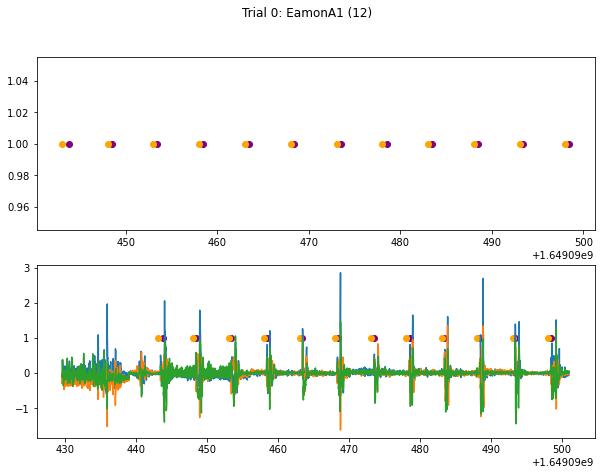

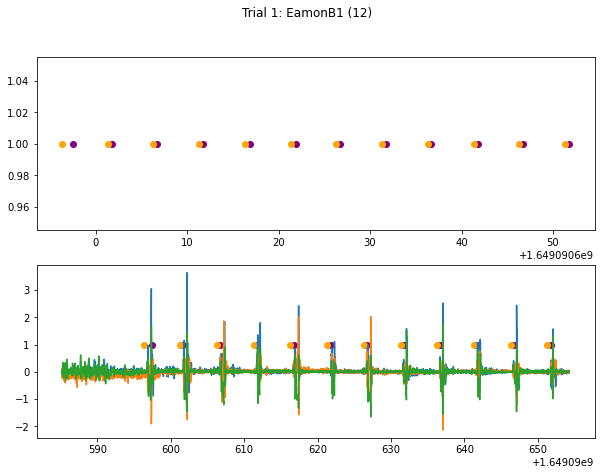

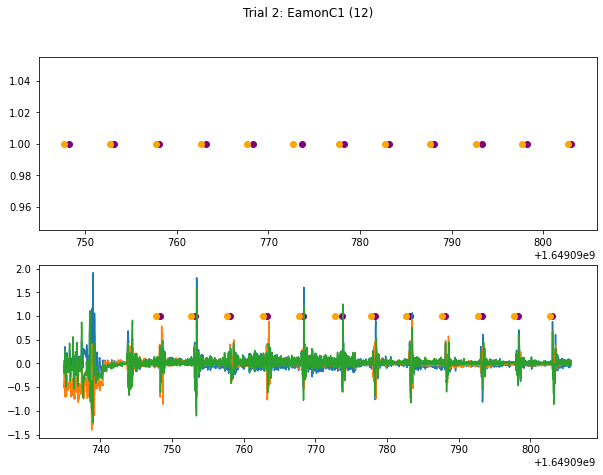

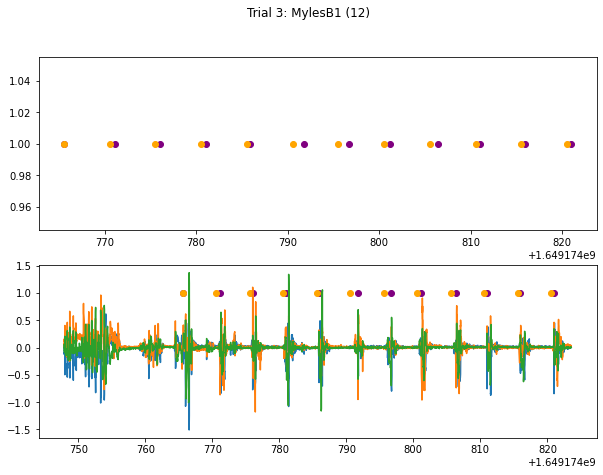

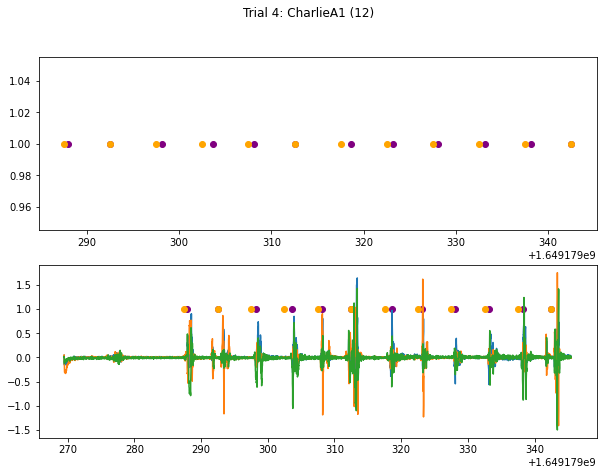

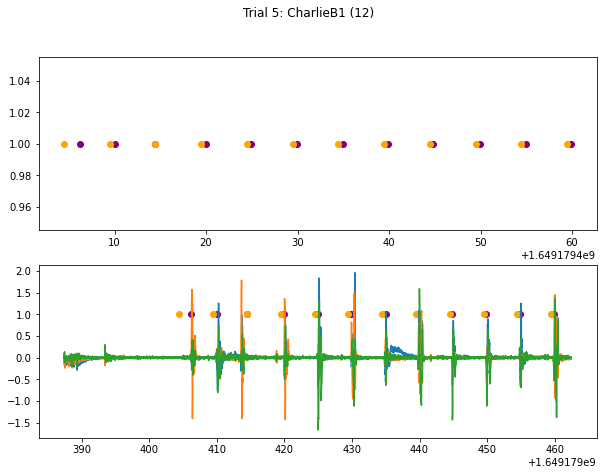

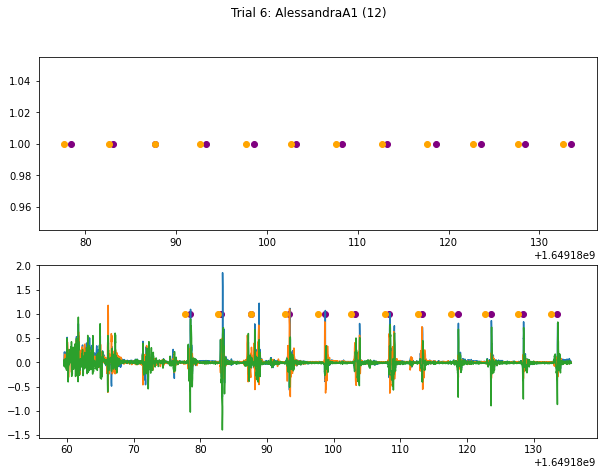

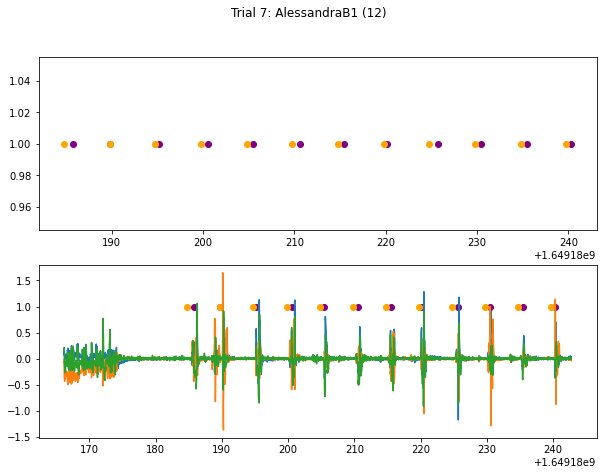

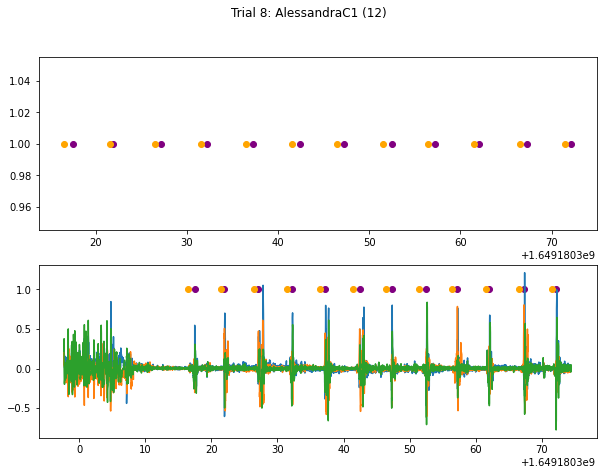

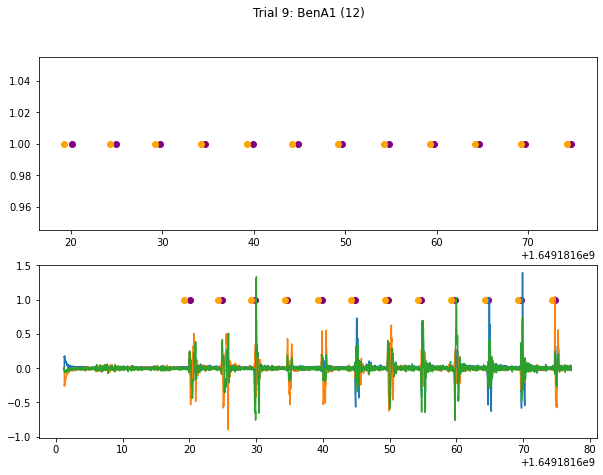

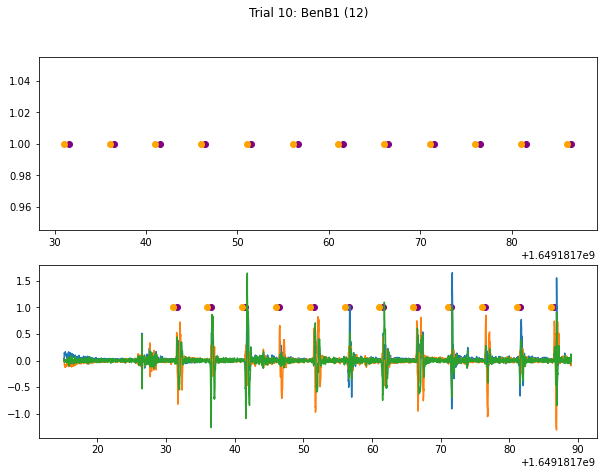

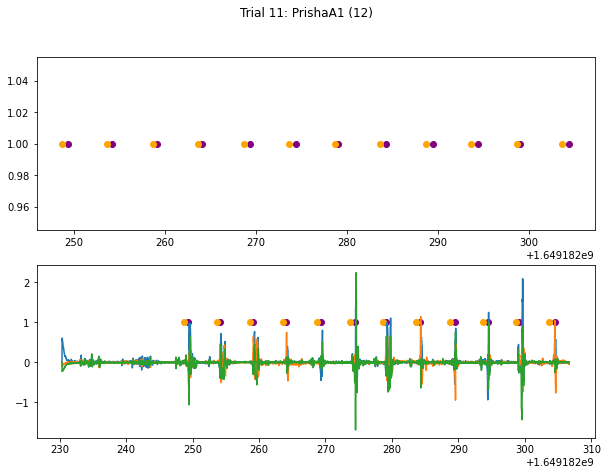

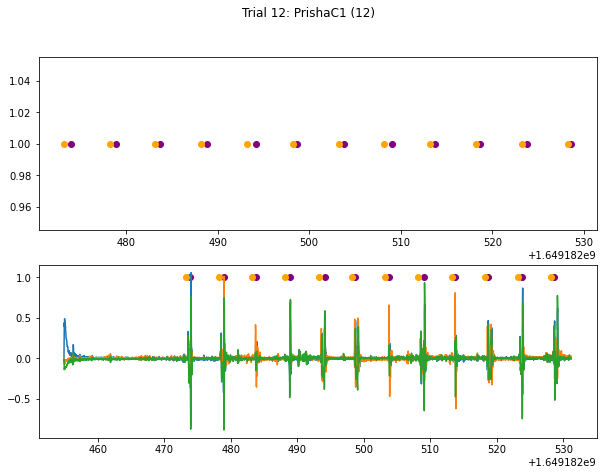

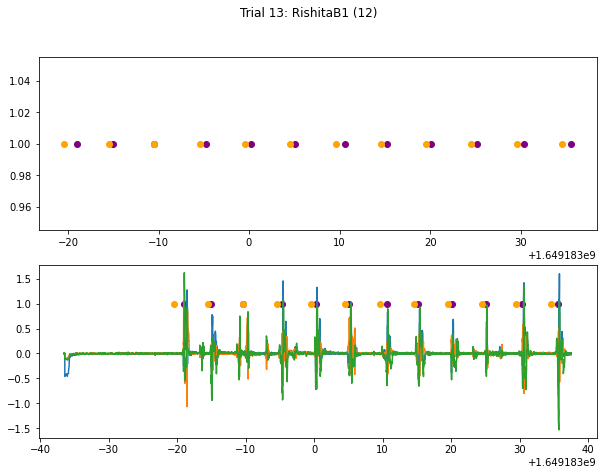

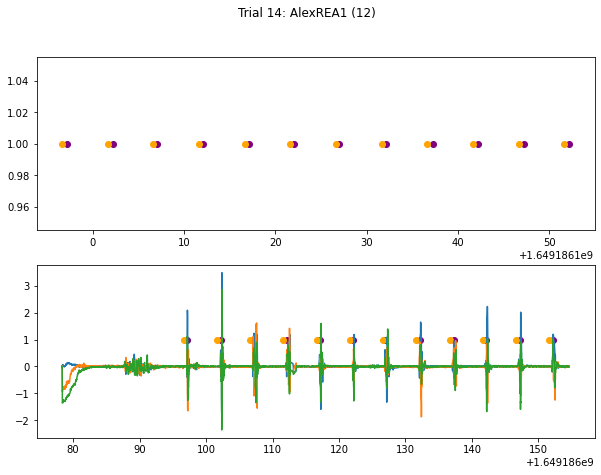

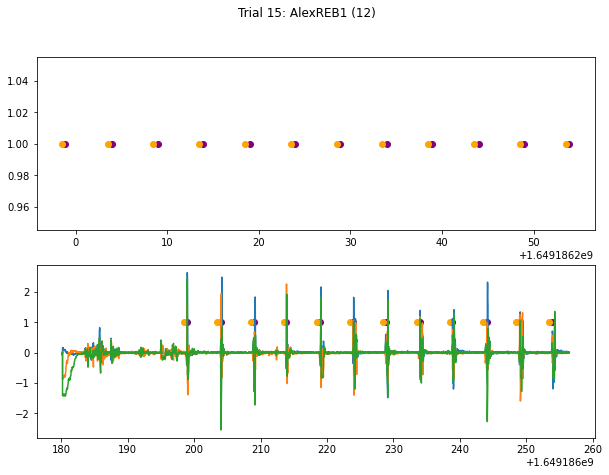

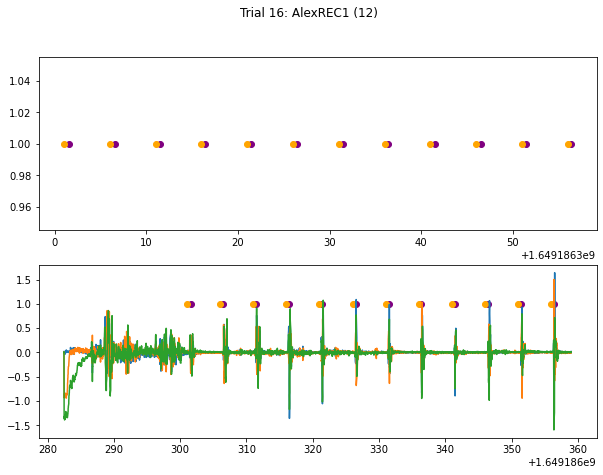

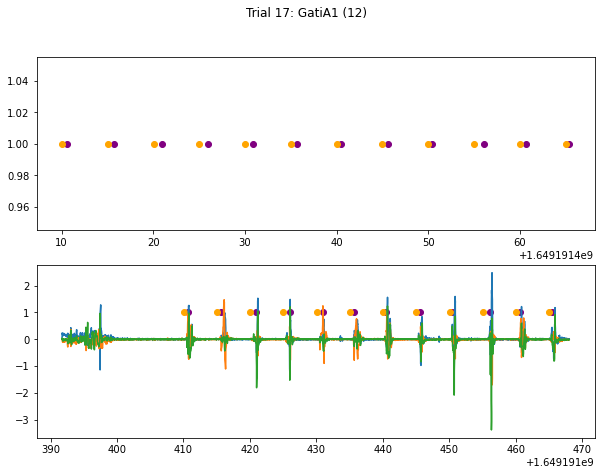

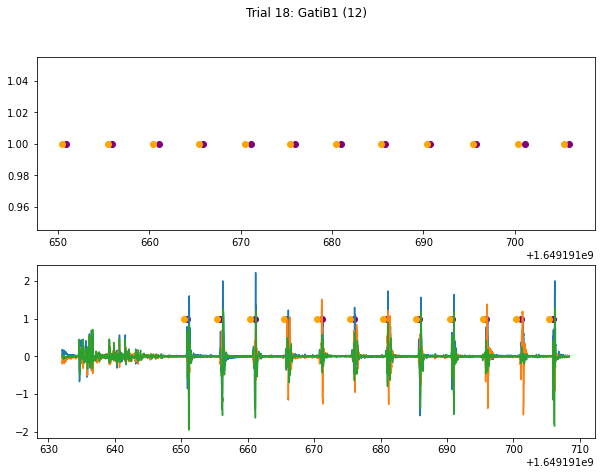

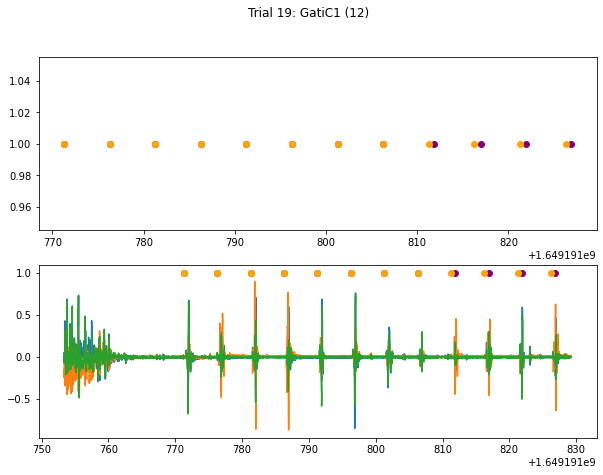

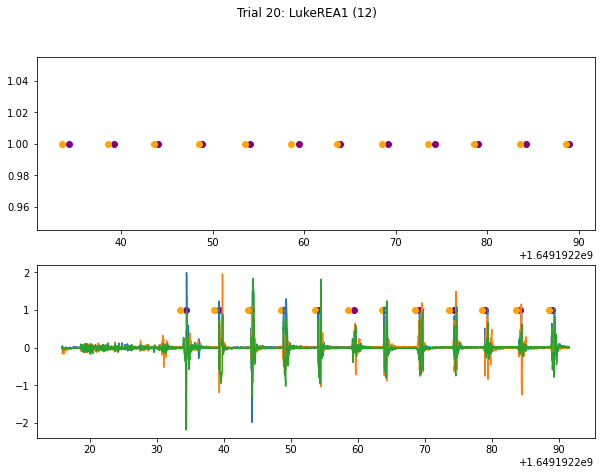

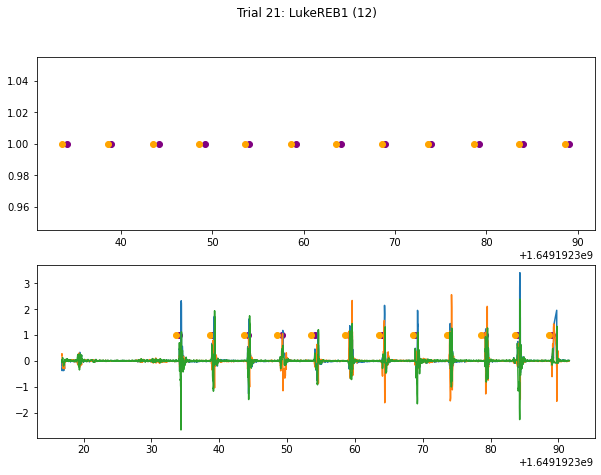

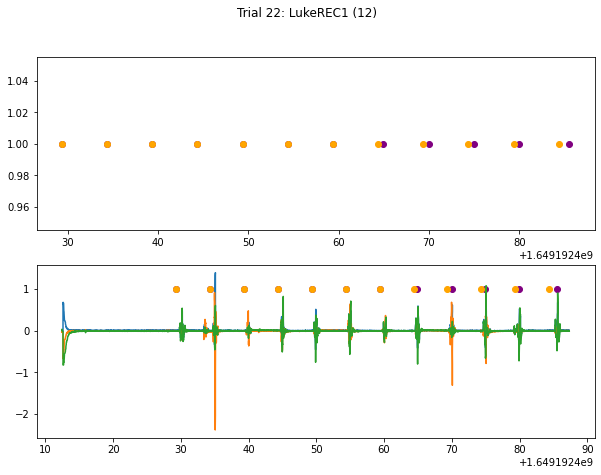

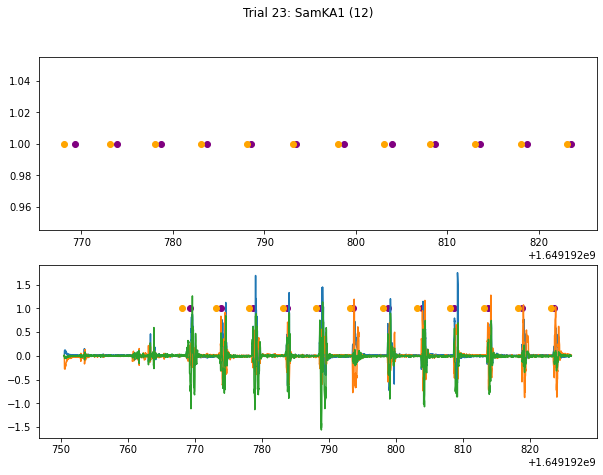

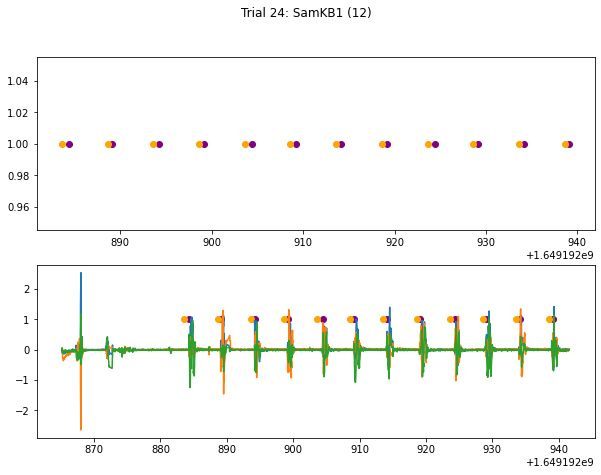

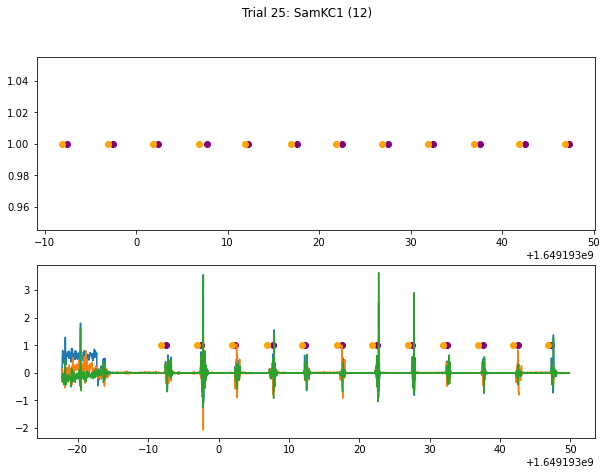

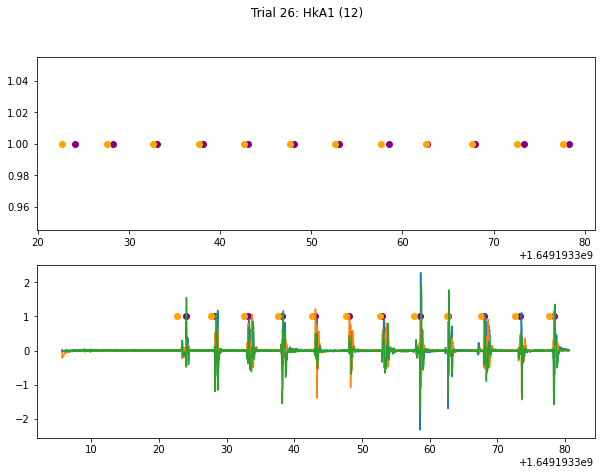

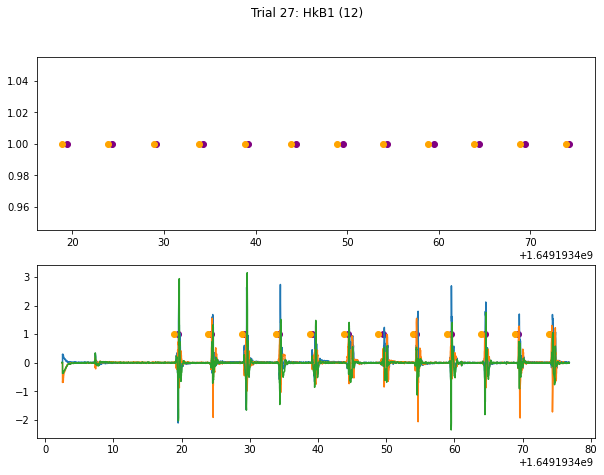

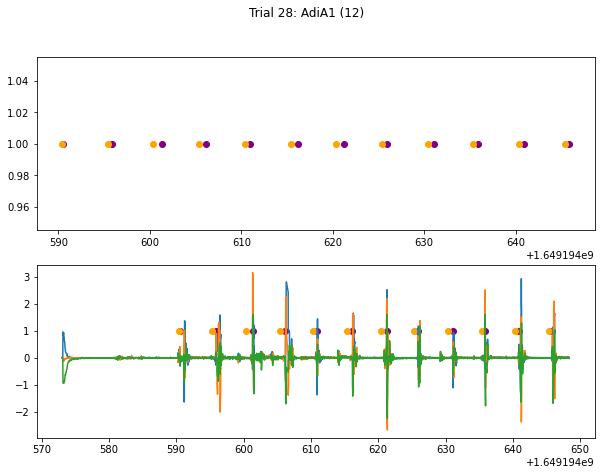

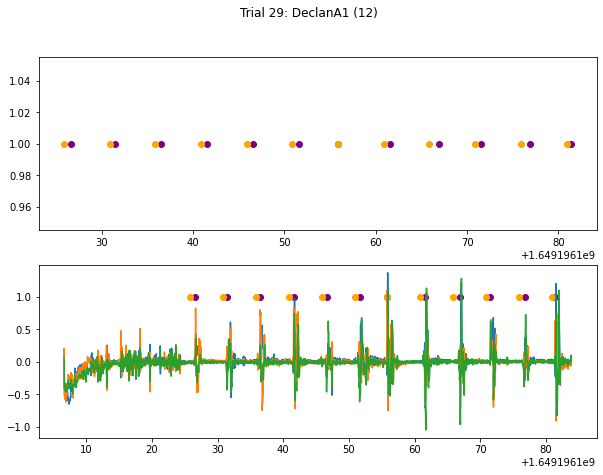

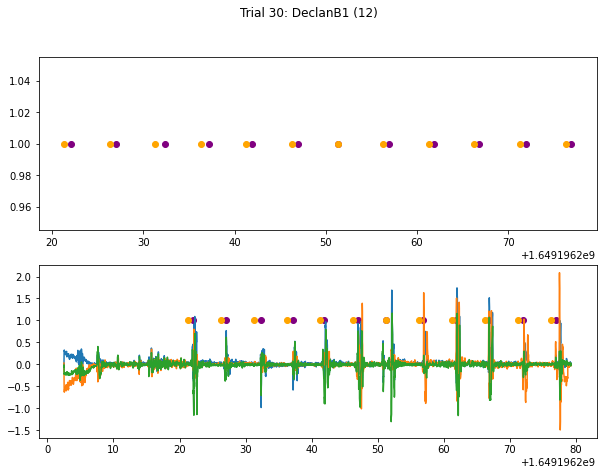

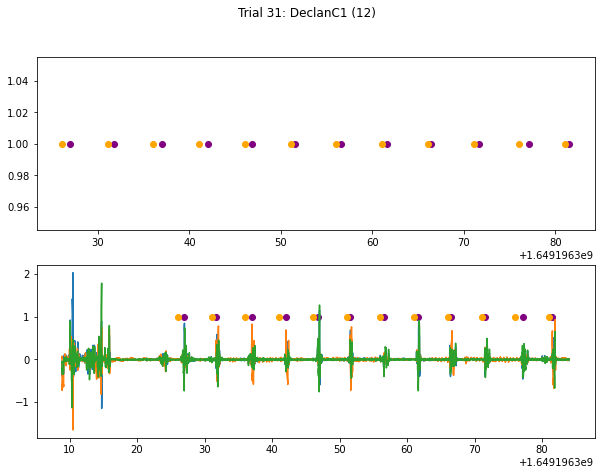

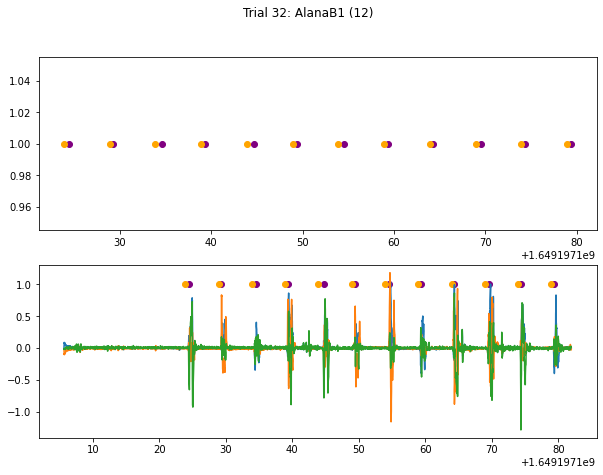

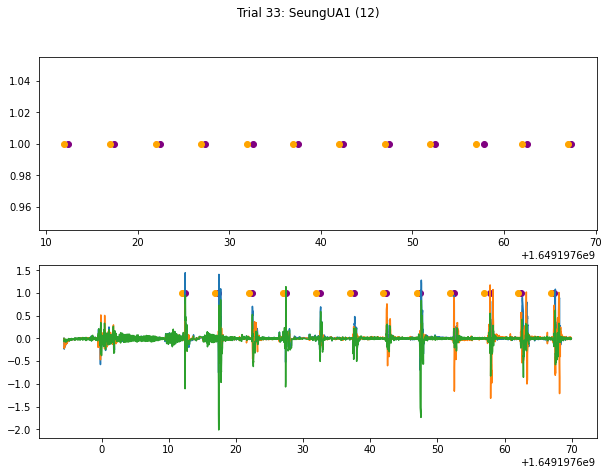

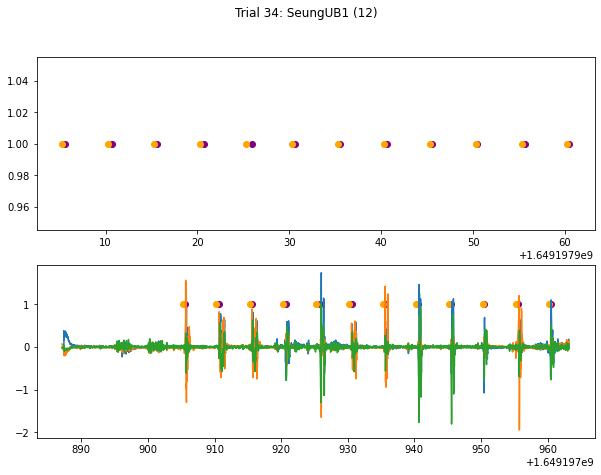

In [5]:
p_a_list = []
p_la_list = []
p_start_list = []
g_labels = []

for i in range(len(meta_data)):
    p_a, p_la, p_start, g_label = parse_json(i, visualize_trace=True)
    p_a_list.append(p_a)
    p_la_list.append(p_la)
    p_start_list.append(p_start)
    g_labels.append(g_label)

0.010122652930632511


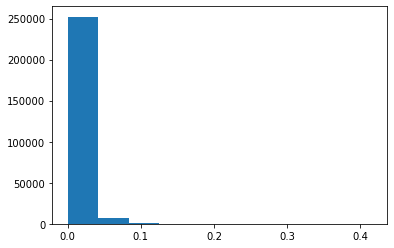

In [185]:
# figure out sampling rate
a_diffs = []
for p_a in p_a_list:
    for i in range(len(p_a["timestamps"]) - 1):
        a_diffs.append(p_a["timestamps"][i + 1] - p_a["timestamps"][i])

plt.hist(a_diffs)
print(np.mean(a_diffs))

0.010187096648853056


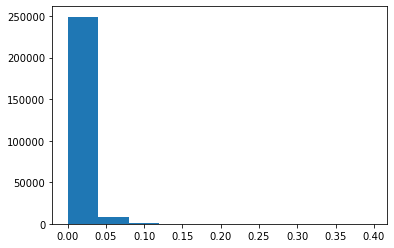

In [186]:
# figure out sampling rate
la_diffs = []
for p_la in p_la_list:
    for i in range(len(p_la["timestamps"]) - 1):
        la_diffs.append(p_la["timestamps"][i + 1] - p_la["timestamps"][i])

plt.hist(la_diffs)
print(np.mean(la_diffs))

In [187]:
2 / 0.01 # 2 seconds for each gesture

200.0

In [188]:
meta_data_gestures = all_meta_data_gestures[all_meta_data_gestures["trial"] < 15]
meta_data_gestures.shape

(180, 8)

# Make metadata file for all gestures

In [189]:
len(g_labels)

35

In [190]:
meta_data.shape

(35, 7)

In [193]:
meta_data["gestures"] = g_labels
meta_data_gestures = meta_data.explode("gestures")
meta_data_gestures["gesture_num"] = meta_data_gestures["gestures"].map({
    "a": 1, "b": 2, "c": 3, "d": 4, "e": 5,
    "f": 6, "g": 7, "h": 8, "i": 9, "j": 10,
    "k": 11, "l": 12, "m": 13, "n": 14})
meta_data_gestures["index"] = range(len(all_meta_data_gestures))
meta_data_gestures = meta_data_gestures.set_index("index")
meta_data_gestures

,Username,Intent,Replicate,Keep,trial,firebase,gestures,gesture_num
index,,,,,,,,
0,Eamon,A,1,keep,0,EamonA1,d,4
1,Eamon,A,1,keep,0,EamonA1,d,4
2,Eamon,A,1,keep,0,EamonA1,i,9
3,Eamon,A,1,keep,0,EamonA1,i,9
4,Eamon,A,1,keep,0,EamonA1,b,2
...,...,...,...,...,...,...,...,...
415,SeungU,B,1,keep,34,SeungUB1,d,4
416,SeungU,B,1,keep,34,SeungUB1,d,4
417,SeungU,B,1,keep,34,SeungUB1,i,9


In [194]:
def extract_segment(p_a, p_la, p_start, tp=100, ofs=25):
    # create segements of gestures
    # 7 measurement channels
    # 100 time points (~1 seconds) (offset 100 from crossing max)
    res = np.zeros((len(p_start["timestamps"]),
                   7,
                   tp))
    
    for i in range((len(p_start["timestamps"]))):
        # get time start of tap
        start = p_start["timestamps"][i]
        
        # get index of first valid time in p_la
        p_la_i = bisect.bisect_left(list(p_la["timestamps"]), start)
        p_la_i -= ofs
        p_la_gesture = p_la.iloc[p_la_i:p_la_i+tp, :]
        res[i][0][:] = p_la_gesture["la_x"]
        res[i][1][:] = p_la_gesture["la_y"]
        res[i][2][:] = p_la_gesture["la_z"]
        
        # get index of first valid time in p_a
        p_a_i = bisect.bisect_left(list(p_a["timestamps"]), start)
        p_a_i -= ofs
        p_a_gesture = p_a.iloc[p_a_i:p_a_i+tp, :]
        res[i][3][:] = p_a_gesture["a_1"]
        res[i][4][:] = p_a_gesture["a_2"]
        res[i][5][:] = p_a_gesture["a_3"]
        res[i][6][:] = p_a_gesture["a_4"]
           
    return res

In [195]:
# create segemented data -- ignore walking trials (too messy)
res = []
for i in range(len(meta_data)): 
    p_a = p_a_list[i]
    p_la = p_la_list[i]
    p_start = p_start_list[i]
    res.append(extract_segment(p_a, p_la, p_start))
    data = np.concatenate(res, axis=0)

In [196]:
data.shape

(420, 7, 100)

# Save Gestures Data + Labels

In [269]:
meta_data_gestures

,Username,Intent,Replicate,Keep,trial,firebase,gestures,gesture_num
index,,,,,,,,
0,Eamon,A,1,keep,0,EamonA1,d,4
1,Eamon,A,1,keep,0,EamonA1,d,4
2,Eamon,A,1,keep,0,EamonA1,i,9
3,Eamon,A,1,keep,0,EamonA1,i,9
4,Eamon,A,1,keep,0,EamonA1,b,2
...,...,...,...,...,...,...,...,...
415,SeungU,B,1,keep,34,SeungUB1,d,4
416,SeungU,B,1,keep,34,SeungUB1,d,4
417,SeungU,B,1,keep,34,SeungUB1,i,9


In [276]:
save_data = data.reshape((data.shape[0], -1))
save_data.shape

(420, 700)

In [277]:
meta_data_gestures.to_csv("meta_gestures.csv")

In [278]:
np.savetxt("data_gestures.csv", save_data)

## Create Train Test Split

Total trials: 35
    
    * session 4 train-test-split: 90:10  
    * test: test 3 (x12 = 36)
        * trials: [2, 6, 11] (randomly chosen)
    * train: train 32 (x12 = 384)

In [197]:
def get_train_test_split(test_trials=[1, 4, 5]):
    """
    Split train and test but keep gestures from the same trial in the same dataset 
    """
    # subset test
    test_labels = meta_data_gestures[meta_data_gestures["trial"].isin(test_trials)][["trial", "gesture_num"]]

    # rest are train
    train_labels = meta_data_gestures[~meta_data_gestures["trial"].isin(test_trials)][["trial", "gesture_num"]]

    test_data = data[test_labels.index]
    test_labels["index"] = range(0, len(test_labels))
    test_labels = test_labels.set_index("index")

    train_data = data[train_labels.index]
    train_labels["index"] = range(0, len(train_labels))
    train_labels = train_labels.set_index("index")
    
    return train_data, train_labels, test_data, test_labels

train_data, train_labels, test_data, test_labels = get_train_test_split(test_trials=[2, 6, 11])

In [198]:
test_data.shape

(36, 7, 100)

In [199]:
train_data.shape

(384, 7, 100)

## Visualize Train Traces

In [200]:
train_labels

,trial,gesture_num
index,,
0,0,4
1,0,4
2,0,9
3,0,9
4,0,2
...,...,...
379,34,4
380,34,4
381,34,9


In [201]:
train_labels["trial"].unique()

array([ 0,  1,  3,  4,  5,  7,  8,  9, 10, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34])

In [202]:
def plot_trace(t_data, t_labels, choose_gesture = 1, choose_channel = 1):
    gestures = t_data[t_labels[t_labels["gesture_num"] == choose_gesture].index]
    print(gestures.shape)

    fig = plt.figure()
    ax = plt.axes()
    for i in range(gestures.shape[0]):
        ax.plot(range(0, gestures.shape[2]), gestures[i][choose_channel])
        ax.plot(range(0, gestures.shape[2]), gestures[i][choose_channel])
        ax.plot(range(0, gestures.shape[2]), gestures[i][choose_channel])
        ax.plot(range(0, gestures.shape[2]), gestures[i][choose_channel])
        ax.plot(range(0, gestures.shape[2]), gestures[i][choose_channel])
        ax.plot(range(0, gestures.shape[2]), gestures[i][choose_channel])

(96, 7, 100)
(96, 7, 100)
(96, 7, 100)
(96, 7, 100)


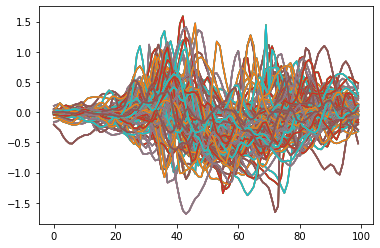

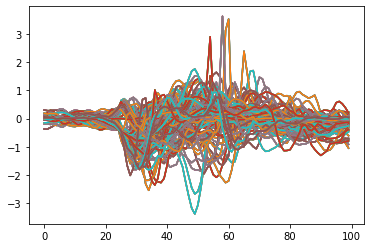

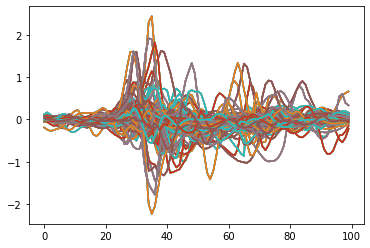

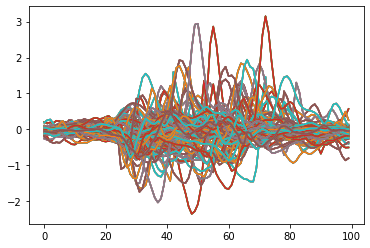

In [205]:
# train data for gesture
plot_trace(train_data, train_labels, choose_gesture = 6, choose_channel = 2)
plot_trace(train_data, train_labels, choose_gesture = 4, choose_channel = 2)
plot_trace(train_data, train_labels, choose_gesture = 2, choose_channel = 2)
plot_trace(train_data, train_labels, choose_gesture = 9, choose_channel = 2)

# Apply PCA and SVM

In [233]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [234]:
def run_pipeline(x_train, x_test, y_train, y_test, n_comp=0, 
                 show_confusion=True, show_pca_gesture=True, show_pca_trial=True):
    # Fit to data and predict gesture
    if n_comp == 0:
        n_pc = min(x_train.shape[0], x_train.shape[1])
    else:
        n_pc = n_comp
    clf = make_pipeline(StandardScaler(), PCA(n_components=n_pc), SVC())
    clf.fit(x_train, y_train["gesture_num"])
    pred_test = clf.predict(x_test)
    acc = accuracy_score(y_test["gesture_num"], pred_test)
    
    if (show_confusion):
        # print accuracy
        print("Prediction accuracy for test dataset")
        print(f"{acc:.2%}")

        # visualize confusion matrirx
        cm = confusion_matrix(y_test["gesture_num"], pred_test)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
        disp.plot()
        plt.show()

        # visualize pca
        scaler = clf.named_steps["standardscaler"]
        x_train_proj = scaler.transform(x_train)
        pca = clf.named_steps["pca"]
        x_train_proj = pca.transform(x_train_proj)

    if (show_pca_gesture):
        # plot train gesture
        fig, ax = plt.subplots(figsize=FIG_SIZE)
        scatter = ax.scatter(
                x=x_train_proj[:, 0],
                y=x_train_proj[:, 1],
                c=y_train["gesture_num"],
                cmap="tab20",
            )
        # produce a legend with the unique colors from the scatter
        legend = ax.legend(*scatter.legend_elements(prop="colors"),
                            loc="lower left", title="Gestures")
        ax.add_artist(legend)

    if (show_pca_trial):
        # plot train trial
        fig, ax = plt.subplots(figsize=FIG_SIZE)
        scatter = ax.scatter(
                x=x_train_proj[:, 0],
                y=x_train_proj[:, 1],
                c=y_train["trial"],
                cmap="tab20c",
            )
        # produce a legend with the unique colors from the scatter
        legend = ax.legend(*scatter.legend_elements(prop="colors"),
                            loc="lower left", title="Trials")
        ax.add_artist(legend)
        print("train trials", y_train["trial"].unique())
        
    return acc

(384, 700)
(36, 700)
Prediction accuracy for test dataset
86.11%


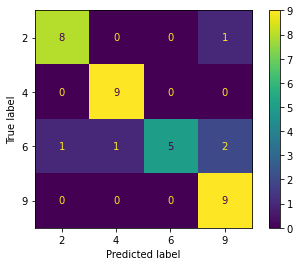

train trials [ 0  1  2  3  4  5  6  7  8  9 10 11 15 16 17 18 19 20 21 22 23 24 25 26
 27 28 29 30 31 32 33 34]


0.8611111111111112

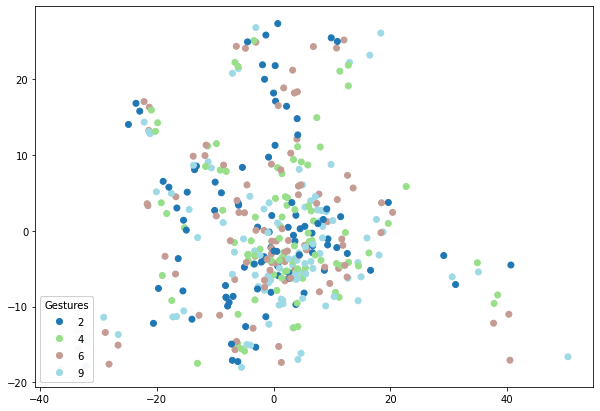

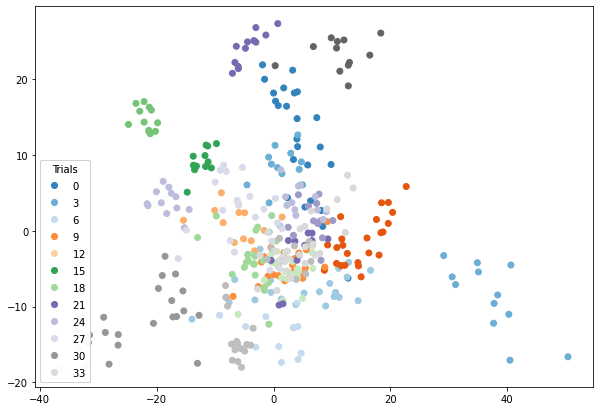

In [235]:
# reshape data to be gestures x ?
# max accuracy --> 77%
x_train = train_data.reshape(train_data.shape[0], -1)
print(x_train.shape)

x_test = test_data.reshape(test_data.shape[0], -1)
print(x_test.shape)

run_pipeline(x_train, x_test, train_labels, test_labels, n_comp=70)

(384, 300)
(36, 300)
Prediction accuracy for test dataset
63.89%


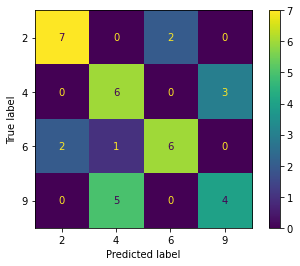

train trials [ 0  1  2  3  4  5  6  7  8  9 10 11 15 16 17 18 19 20 21 22 23 24 25 26
 27 28 29 30 31 32 33 34]


0.6388888888888888

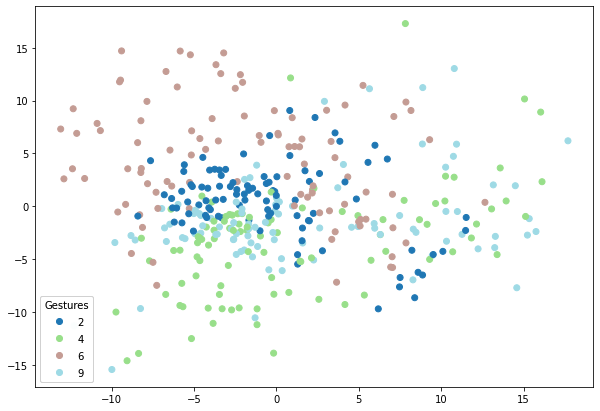

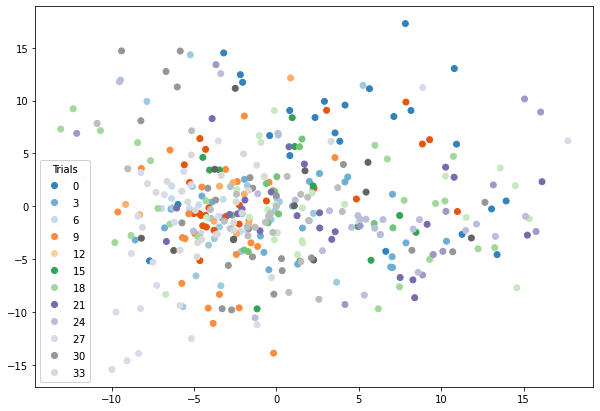

In [236]:
# reshape data to be gestures x ?, only use linear acceleration
# max accuracy --> 77%
x_train = train_data[:, 0:3, :].reshape(train_data.shape[0], -1)
print(x_train.shape)

x_test = test_data[:, 0:3, :].reshape(test_data.shape[0], -1)
print(x_test.shape)

run_pipeline(x_train, x_test, train_labels, test_labels, n_comp=70)

## BUG: color scheme is strange for trials-colored PCA plot

## Cross Validate Chosen Feature Set
* A set of 4 gestures was chosen because they appeared most commonly in the good feature set (distinguishable in test set at 83% with PCA + SVD) and themselves created a good feature set
    * 2 (swipe right)
    * 4 (swipe down)
    * 6 (counter bottom)
    * 9 (tap)
* The test set was comprised of 3 representative trials (12 gestures instances total):
    * 1 (45 deg, in air, chest-level)
    * 4 (0 deg, in air, thigh-level)
    * 5 (0 deg, on surface, thigh-level)
* Train set was comprised of remaining 6 trials (24 gesture instances total)

*With Cross Validation*: check if [2, 4, 6, 9] feature set is robustly good across other test trials

In [237]:
import itertools

In [238]:
def run_pipeline_on_gesture_list(train_data, train_labels, test_data, test_labels,
                                 gesture_list = [2, 4, 6, 9],
                                 show_confusion=False, show_pca_gesture=False, show_pca_trial=False):
    # choose gestures
    train_labels_chosen_gestures = train_labels[train_labels["gesture_num"].isin(gesture_list)]
    train_data_chosen_gestures = train_data[train_labels_chosen_gestures.index]
    train_labels_chosen_gestures

    test_labels_chosen_gestures = test_labels[test_labels["gesture_num"].isin(gesture_list)]
    test_data_chosen_gestures = test_data[test_labels_chosen_gestures.index]
    test_labels_chosen_gestures

    # reshape data to be gestures x ?
    # max accuracy --> 50%
    x_train = train_data_chosen_gestures[:, 0:3, :].reshape(train_data_chosen_gestures.shape[0], -1)
    print(x_train.shape)

    x_test = test_data_chosen_gestures[:, 0:3, :].reshape(test_data_chosen_gestures.shape[0], -1)
    print(x_test.shape)

    acc = run_pipeline(x_train, x_test, train_labels_chosen_gestures, test_labels_chosen_gestures, 
                       show_confusion=show_confusion, show_pca_gesture=show_pca_gesture, show_pca_trial=show_pca_trial)
    return acc

(384, 300)
(36, 300)
Prediction accuracy for test dataset
61.11%


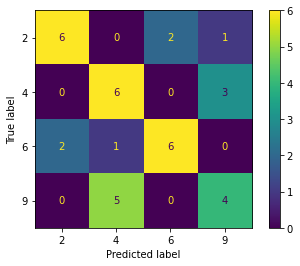

train trials [ 0  1  2  3  4  5  6  7  8  9 10 11 15 16 17 18 19 20 21 22 23 24 25 26
 27 28 29 30 31 32 33 34]


0.6111111111111112

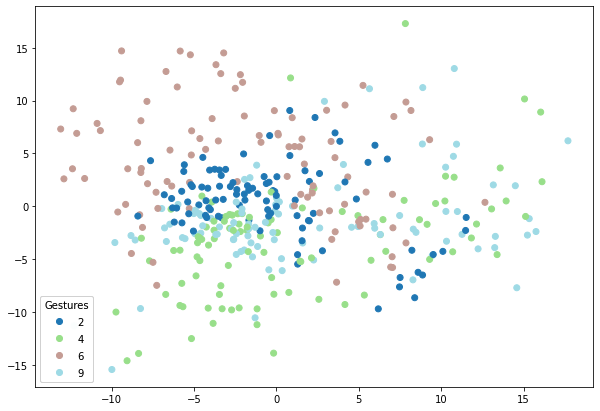

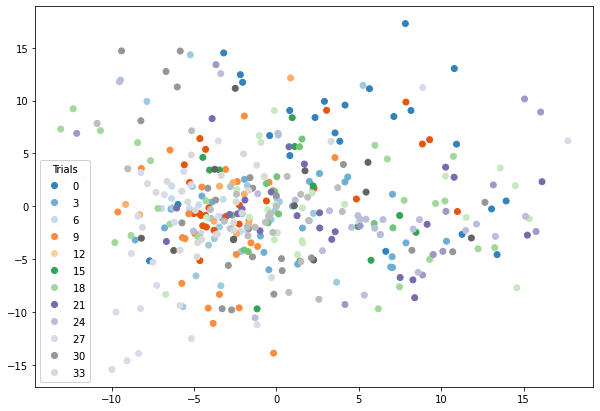

In [239]:
run_pipeline_on_gesture_list(train_data, train_labels, test_data, test_labels, 
                             gesture_list = [2, 4, 6, 9],
                             show_confusion=True, show_pca_gesture=True, show_pca_trial=True)

In [248]:
gesture_list = [2, 4, 6, 9]
comb_test_trials = list(itertools.combinations(range(0, 15), 3))
cross_val_acc = []
for ta, tb, tc in comb_test_trials:
    train_data, train_labels, test_data, test_labels = get_train_test_split(test_trials=[ta, tb, tc])
    print(train_data.shape, test_data.shape)
    print(len(train_labels), len(test_labels))
    acc = run_pipeline_on_gesture_list(train_data, train_labels, test_data, test_labels,
                                      gesture_list=gesture_list)
    cross_val_acc.append(acc)
    
df_cross_val = pd.DataFrame({
    "a": [a for a, b, c in comb_test_trials],
    "b": [b for a, b, c in comb_test_trials],
    "c": [c for a, b, c in comb_test_trials],
    "aIntent": [meta_data["Intent"][a] for a, b, c in comb_test_trials],
    "bIntent": [meta_data["Intent"][b] for a, b, c in comb_test_trials],
    "cIntent": [meta_data["Intent"][c] for a, b, c in comb_test_trials],
    "cross_val_acc": cross_val_acc 
})

(384, 7, 100) (36, 7, 100)
384 36
(384, 300)
(36, 300)
(384, 7, 100) (36, 7, 100)
384 36
(384, 300)
(36, 300)
(384, 7, 100) (36, 7, 100)
384 36
(384, 300)
(36, 300)
(384, 7, 100) (36, 7, 100)
384 36
(384, 300)
(36, 300)
(384, 7, 100) (36, 7, 100)
384 36
(384, 300)
(36, 300)
(384, 7, 100) (36, 7, 100)
384 36
(384, 300)
(36, 300)
(384, 7, 100) (36, 7, 100)
384 36
(384, 300)
(36, 300)
(384, 7, 100) (36, 7, 100)
384 36
(384, 300)
(36, 300)
(384, 7, 100) (36, 7, 100)
384 36
(384, 300)
(36, 300)
(384, 7, 100) (36, 7, 100)
384 36
(384, 300)
(36, 300)
(384, 7, 100) (36, 7, 100)
384 36
(384, 300)
(36, 300)
(384, 7, 100) (36, 7, 100)
384 36
(384, 300)
(36, 300)
(384, 7, 100) (36, 7, 100)
384 36
(384, 300)
(36, 300)
(384, 7, 100) (36, 7, 100)
384 36
(384, 300)
(36, 300)
(384, 7, 100) (36, 7, 100)
384 36
(384, 300)
(36, 300)
(384, 7, 100) (36, 7, 100)
384 36
(384, 300)
(36, 300)
(384, 7, 100) (36, 7, 100)
384 36
(384, 300)
(36, 300)
(384, 7, 100) (36, 7, 100)
384 36
(384, 300)
(36, 300)
(384, 7, 1

(384, 7, 100) (36, 7, 100)
384 36
(384, 300)
(36, 300)
(384, 7, 100) (36, 7, 100)
384 36
(384, 300)
(36, 300)
(384, 7, 100) (36, 7, 100)
384 36
(384, 300)
(36, 300)
(384, 7, 100) (36, 7, 100)
384 36
(384, 300)
(36, 300)
(384, 7, 100) (36, 7, 100)
384 36
(384, 300)
(36, 300)
(384, 7, 100) (36, 7, 100)
384 36
(384, 300)
(36, 300)
(384, 7, 100) (36, 7, 100)
384 36
(384, 300)
(36, 300)
(384, 7, 100) (36, 7, 100)
384 36
(384, 300)
(36, 300)
(384, 7, 100) (36, 7, 100)
384 36
(384, 300)
(36, 300)
(384, 7, 100) (36, 7, 100)
384 36
(384, 300)
(36, 300)
(384, 7, 100) (36, 7, 100)
384 36
(384, 300)
(36, 300)
(384, 7, 100) (36, 7, 100)
384 36
(384, 300)
(36, 300)
(384, 7, 100) (36, 7, 100)
384 36
(384, 300)
(36, 300)
(384, 7, 100) (36, 7, 100)
384 36
(384, 300)
(36, 300)
(384, 7, 100) (36, 7, 100)
384 36
(384, 300)
(36, 300)
(384, 7, 100) (36, 7, 100)
384 36
(384, 300)
(36, 300)
(384, 7, 100) (36, 7, 100)
384 36
(384, 300)
(36, 300)
(384, 7, 100) (36, 7, 100)
384 36
(384, 300)
(36, 300)
(384, 7, 1

(384, 7, 100) (36, 7, 100)
384 36
(384, 300)
(36, 300)
(384, 7, 100) (36, 7, 100)
384 36
(384, 300)
(36, 300)
(384, 7, 100) (36, 7, 100)
384 36
(384, 300)
(36, 300)
(384, 7, 100) (36, 7, 100)
384 36
(384, 300)
(36, 300)
(384, 7, 100) (36, 7, 100)
384 36
(384, 300)
(36, 300)
(384, 7, 100) (36, 7, 100)
384 36
(384, 300)
(36, 300)
(384, 7, 100) (36, 7, 100)
384 36
(384, 300)
(36, 300)
(384, 7, 100) (36, 7, 100)
384 36
(384, 300)
(36, 300)
(384, 7, 100) (36, 7, 100)
384 36
(384, 300)
(36, 300)
(384, 7, 100) (36, 7, 100)
384 36
(384, 300)
(36, 300)
(384, 7, 100) (36, 7, 100)
384 36
(384, 300)
(36, 300)
(384, 7, 100) (36, 7, 100)
384 36
(384, 300)
(36, 300)
(384, 7, 100) (36, 7, 100)
384 36
(384, 300)
(36, 300)
(384, 7, 100) (36, 7, 100)
384 36
(384, 300)
(36, 300)
(384, 7, 100) (36, 7, 100)
384 36
(384, 300)
(36, 300)
(384, 7, 100) (36, 7, 100)
384 36
(384, 300)
(36, 300)
(384, 7, 100) (36, 7, 100)
384 36
(384, 300)
(36, 300)
(384, 7, 100) (36, 7, 100)
384 36
(384, 300)
(36, 300)
(384, 7, 1

(384, 7, 100) (36, 7, 100)
384 36
(384, 300)
(36, 300)
(384, 7, 100) (36, 7, 100)
384 36
(384, 300)
(36, 300)
(384, 7, 100) (36, 7, 100)
384 36
(384, 300)
(36, 300)
(384, 7, 100) (36, 7, 100)
384 36
(384, 300)
(36, 300)
(384, 7, 100) (36, 7, 100)
384 36
(384, 300)
(36, 300)


In [256]:
df_cross_val = df_cross_val.sort_values("cross_val_acc")
df_cross_val

,a,b,c,aIntent,bIntent,cIntent,cross_val_acc,cross_val_acc_percent
259,3,6,12,B,A,C,0.472222,47.222222
34,0,3,13,A,B,B,0.500000,50.000000
13,0,2,3,A,C,B,0.500000,50.000000
287,3,12,13,B,C,B,0.500000,50.000000
112,1,3,13,B,B,B,0.500000,50.000000
...,...,...,...,...,...,...,...,...
361,5,10,11,B,B,A,0.916667,91.666667
345,5,7,10,B,B,B,0.944444,94.444444
435,9,10,11,A,B,A,0.944444,94.444444
405,7,9,10,B,A,B,0.972222,97.222222


98.24175824175825 of cross-val combs have greater than 50% acc


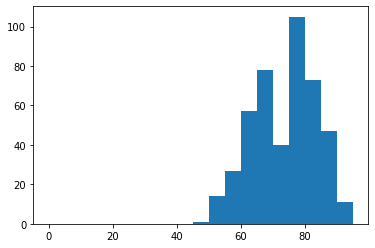

In [257]:
df_cross_val["cross_val_acc_percent"] = df_cross_val['cross_val_acc'].apply(lambda x: x * 100)
plt.hist(df_cross_val["cross_val_acc_percent"], bins=range(0, 100, 5))
print(100 * df_cross_val[df_cross_val["cross_val_acc"] > .5].shape[0] / df_cross_val.shape[0], "of cross-val combs have greater than 50% acc")

In [258]:
df_cross_val[df_cross_val["cross_val_acc"] > .5].shape

(447, 8)

In [259]:
df_cross_val[df_cross_val["cross_val_acc"] > .8].shape

(133, 8)

In [260]:
df_cross_val[df_cross_val["cross_val_acc"] > .9].shape

(13, 8)

In [267]:
df_cross_val.head(50)

,a,b,c,aIntent,bIntent,cIntent,cross_val_acc,cross_val_acc_percent
259,3,6,12,B,A,C,0.472222,47.222222
34,0,3,13,A,B,B,0.500000,50.000000
13,0,2,3,A,C,B,0.500000,50.000000
287,3,12,13,B,C,B,0.500000,50.000000
112,1,3,13,B,B,B,0.500000,50.000000
255,3,6,8,B,A,C,0.500000,50.000000
260,3,6,13,B,A,B,0.500000,50.000000
272,3,8,12,B,C,C,0.500000,50.000000
273,3,8,13,B,C,B,0.527778,52.777778
27,0,3,6,A,B,A,0.527778,52.777778


In [268]:
df_cross_val.tail(50)

,a,b,c,aIntent,bIntent,cIntent,cross_val_acc,cross_val_acc_percent
144,1,7,11,B,B,A,0.861111,86.111111
225,2,10,11,C,B,A,0.861111,86.111111
351,5,8,10,B,C,B,0.861111,86.111111
373,6,7,10,A,B,B,0.861111,86.111111
191,2,5,7,C,B,B,0.861111,86.111111
129,1,5,11,B,B,A,0.861111,86.111111
346,5,7,11,B,B,A,0.861111,86.111111
421,8,9,11,C,A,A,0.861111,86.111111
406,7,9,11,B,A,A,0.861111,86.111111
65,0,7,10,A,B,B,0.861111,86.111111
